# Amazon Customer Review Sentiment Analysis

This notebook aims to analyze customer review data for a product listed on Amazon and perform sentiment analysis on the reviews. The goal is to gain insights into customer sentiments and assess the effectiveness of different modeling methods in accurately predicting sentiment based on the provided reviews.

The analysis begins with data cleaning, where the raw review data is processed to remove noise, handle missing values, and apply text preprocessing techniques such as stemming and removing special characters. After cleaning, the data is explored through visualizations and statistical summaries to gain a better understanding of the distribution of sentiments and identify any patterns or trends.

Next, the cleaned data is split into training and test sets to prepare for modeling. The reviews are vectorized using suitable techniques such as Count Vector and TF-IDF to transform them into numerical representations that can be used as input for the models. The sentiment labels are encoded accordingly, mapping them to numeric values for classification.

Multiple modeling methods are then applied to the vectorized training data. These include Naive Bayes, Logistic Regression, and Support Vector Machines (SVM). Each model is trained on the training set and evaluated using the validation set. Metrics such as accuracy, precision, recall, and F1 score are computed to assess the performance of each model.

In [1]:
#Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob   
import re
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

#Packages for model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


#Packages for evaluation
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


#Filters and display options
import warnings
warnings.filterwarnings('ignore')
warnings.warn("text too long")
pd.set_option('display.max_columns', None)
%matplotlib inline
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#Starting off by importing the csv file and reading the data
reviews = pd.read_csv('../data/amazon_reviews.csv', index_col=0)

In [3]:
#Creating a function for data frame summary statistics and viewing the data frame
def overview(df, head=5, tail=5):
   print("  TYPES   ".center(82, '-'))
   print(df.dtypes)
   
   print("  SHAPE   ".center(82,'-'))
   print(f"Rows: {df.shape[0]}")
   print(f"Columns: {df.shape[1]}")
   
   print("  DUPLICATES  ".center(82,'-'))
   print(df.duplicated().sum())
   
   print("  NaN VALUES".center(82,'-'))
   print(df.isna().sum())
   
   print("  QUANTILES   ".center(82,'-'))
   print(df.quantile([0,0.05,0.50,0.95,0.99,1]).T)
   
   print("  DATAFRAME PREVIEW   ".center(82, '-'))
   print(df.head(n=5))
   print(df.tail(n=5))

In [4]:
#Calling the function
overview(reviews)

------------------------------------  TYPES   ------------------------------------
reviewerName             object
overall                 float64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
------------------------------------  SHAPE   ------------------------------------
Rows: 4915
Columns: 11
----------------------------------  DUPLICATES  ----------------------------------
0
-----------------------------------  NaN VALUES-----------------------------------
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_boun

Based on the overview function call, we can see that most of the data frame columns are either int or float types. I can also see that there are 4915 rows spanning across 12 columns of data. As for null values there appear to only be 2, so there won't be much cleaning up to do of null values in this data set at first glance. I'm also viewing the first 5 and last 5 rows of the data frame to get a general understanding of what's contained in the data. Based on the nature of the data, it looks like the 'overall' column can be used as the target variable. The float type will be replaced with string values, 0-2 will be seen as negative, 3 will be neutral and 4-5 will be positive.

## Step 1:
Remove any NaN values

In [5]:
#Taking a look at the NaN value before replacing it 
reviews['reviewerName'].head()

0             NaN
1            0mie
2             1K3
3             1m2
4    2&amp;1/2Men
Name: reviewerName, dtype: object

Since the only NaN value in this column is a customer name, we will assign a random name to the customer. This step is be taken since the reviewernames have no affect on our dataset. 

In [6]:
reviews['reviewerName'].fillna('randomName', inplace=True)

Next up is the reviewText column, since the contents of this column are going to be used later to perform sentiment analysis, any NaN values here will have to be dropped instead of replaced. To do this, I'm going to drop the entire row that contains the NaN value. 

In [7]:
reviews.dropna(inplace=True)

## Step 2:
Convert the float column 'overall' to sentiment string values 

In [8]:
#Creating a simple function to return sentiment type
def sentimentType(score):
    if score == 4.0 or score == 5.0:
        return 'Positive'
    elif score == 3.0:
        return 'Neutral'
    elif score == 1.0 or score == 2.0:
        return 'Negative'

In [9]:
#Applying the function created earlier to the overall column
reviews['overall'] = reviews['overall'].apply(sentimentType)
reviews.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,randomName,Positive,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,0mie,Positive,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,1K3,Positive,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,1m2,Positive,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,2&amp;1/2Men,Positive,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


Text(0.5, 0, 'Sentiment Type')

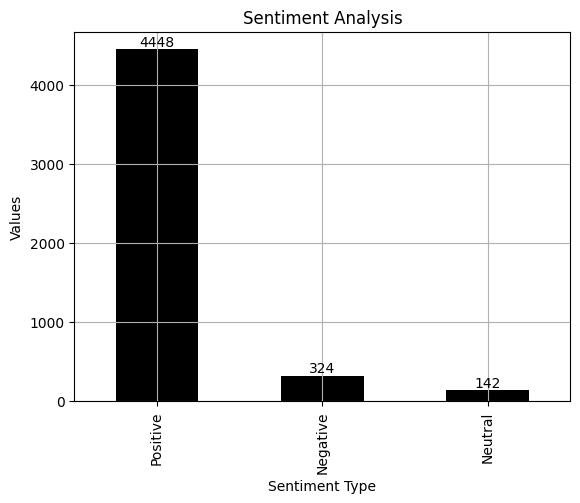

In [10]:
#Visualizing the data after converting overall column to string values 
ax = reviews['overall'].value_counts().plot(kind='bar', grid=True, colormap='gray')
ax.bar_label(ax.containers[0])
plt.title('Sentiment Analysis')
plt.ylabel('Values')
plt.xlabel('Sentiment Type')

## Step 3:
Explore the reviewText column and convert to string type/lower case 

In [11]:
#Converting the values in reviewText to string values and changing the case to lower
reviews['reviewText'] = reviews['reviewText'].astype(str).apply(lambda text: text.lower())

Next, a function will be created to remove URLs, special characters, mentions and any non-alphanumeric characters from the reviews. The text will also be converted to lowercase and tokenized. Stopwords will be removed and stemmming will be performed - words will be converted to their base or root form. This will ensure that words aren't double counted. 

In [12]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def text_processing(text):
    text = re.sub(r"https?\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text_tokens = word_tokenize(text.lower())
    filtered_text = [i for i in text_tokens if i not in stop_words]
    stem_wrods = [stemmer.stem(w) for w in filtered_text]
    return " ".join(stem_wrods)

In [13]:
#Applying the function to the review dataset for preprocessing 
reviews["reviewText"] = reviews['reviewText'].apply(text_processing)

In [14]:
#Saving the first few lines of reviews to a sample dataframe for review
sample_reviews = reviews['reviewText'].head(10)

In [15]:
#Dropping all duplicates values in each comment
reviews = reviews.drop_duplicates('reviewText')

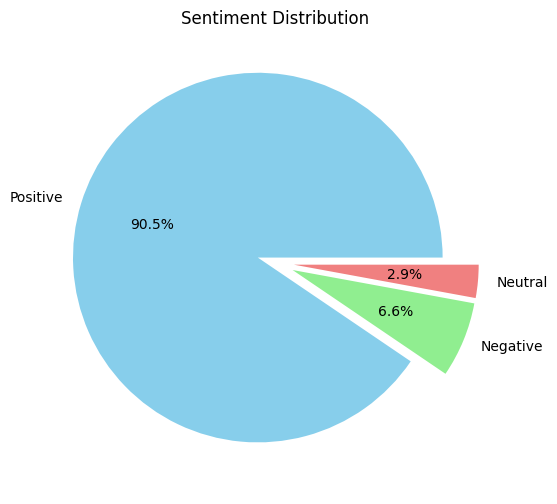

In [16]:
sentiment_counts = reviews['overall'].value_counts(normalize=True) * 100
colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'pink']
explode = (0.1, 0.1, 0.1)
#Plotting the pie chart
plt.figure(figsize=(8,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, explode=explode)
plt.title('Sentiment Distribution')
plt.show()

Based on the pie chart we can see that about 90.5% of reviews for this product were positive, 6.6% were negative and 2.9% neutral. Based on those numbers, we know two things:
1. This product looks to be a succesful product for the business based on reviews, but the revenue attributed to the product would have to be investigated before making a confident decision on the product.
2. We should perform outreach to 9.5% of the customers that reviewed this product, that is a sum of both the neutral and negative reviews. We should reach out to the negative comments to understand what was there experience and how could we make improvements. For the neutral reviews we should also be reaching out to understand what they liked about the product and what was missing from the product that stopped them from truly loving it. 

## Step 4:
Creating a visual representation of the most common words found in each of the three categories:
1. Positive
2. Neutral
3. Negative

The word count will be visualized in picture format and in bar chart format. 

In [17]:
font_path = "../font/Cookies and Cheese Bold -Demo.ttf"

#Defining a function to count and visualize the number 
def frequent_words(comments, header):
    text = ' '.join([word for word in comments['reviewText']])
    plt.figure(figsize = (15,15), facecolor='None')
    wordcloud = WordCloud(max_words=500, width=1600, height=800, font_path=font_path).generate(text)
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most frequent words in {header}', fontsize=19)
    plt.show()

In [18]:
#Creating variables to isolate the positive, neutral and negative comments
positive_comments = reviews[reviews['overall'] == 'Positive']
neutral_comments = reviews[reviews['overall'] == 'Neutral'] 
negative_comments = reviews[reviews['overall'] == 'Negative']  

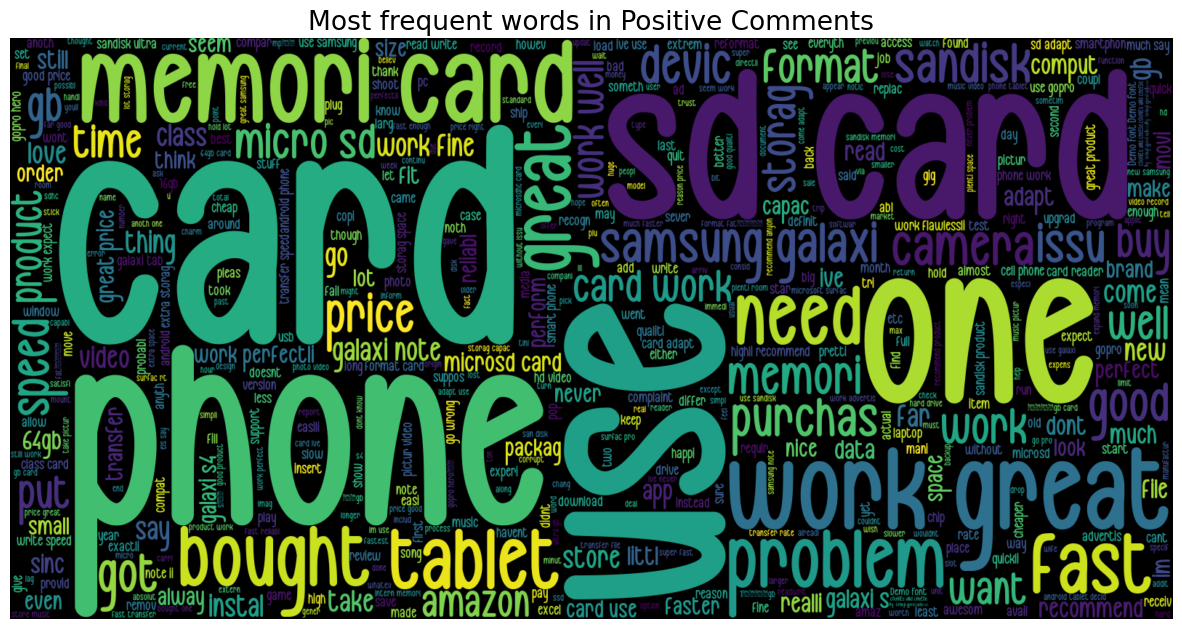

In [19]:
frequent_words(positive_comments, 'Positive Comments')

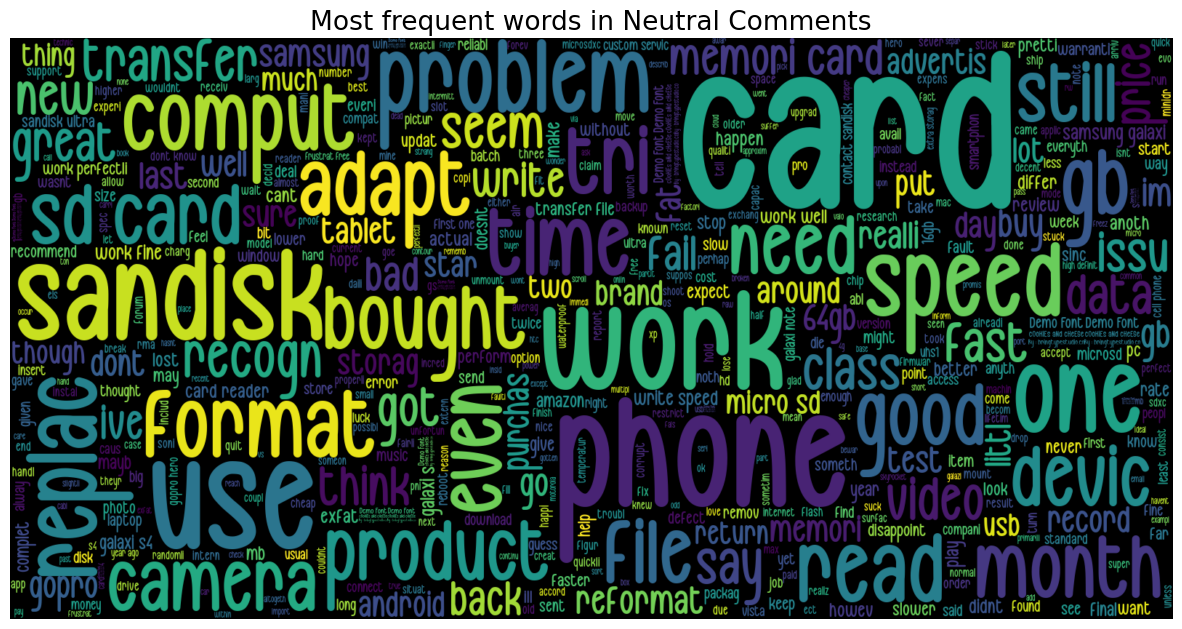

In [20]:
frequent_words(neutral_comments, 'Neutral Comments')

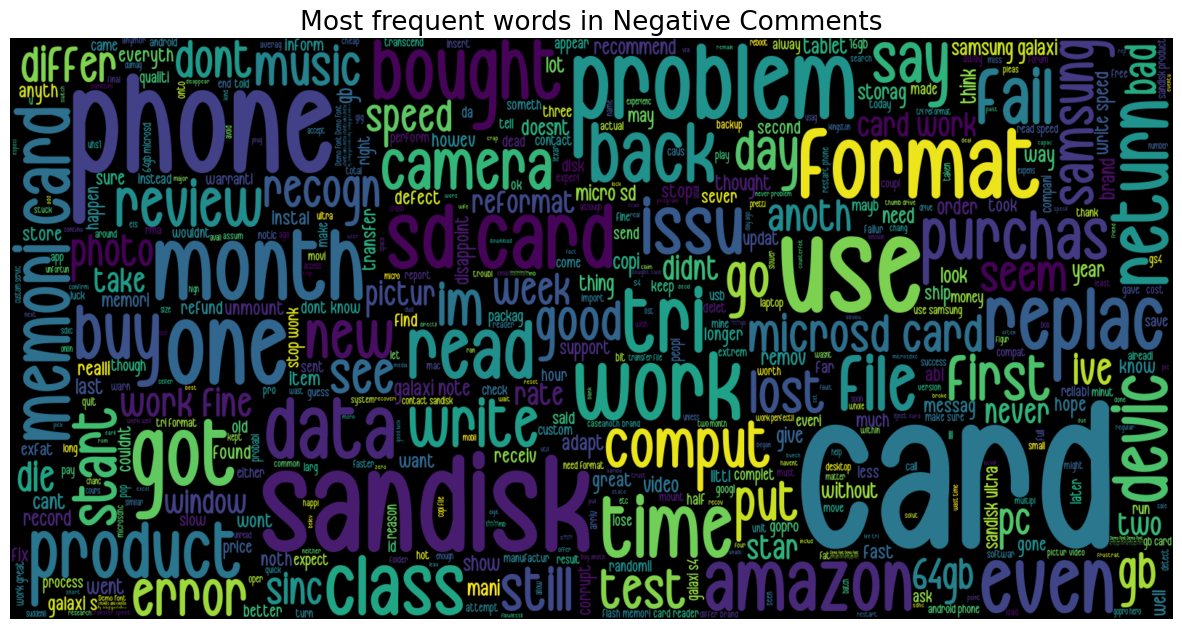

In [21]:
frequent_words(negative_comments, 'Negative Comments')

In [22]:
# Defining a function to count and visualize the most frequent words using a bar chart
def count_freqwords(comments, category):
    text = ' '.join([word for word in comments['reviewText']])
    word_tokens = text.split()
    word_counter = Counter(word_tokens)
    most_common = word_counter.most_common(10)  # Get the top 10 most frequent words

    #Creating a bar chart
    plt.figure(figsize=(10, 6))
    words, counts = zip(*most_common)
    plt.bar(words, counts)
    plt.title(f'Most frequent words in {category}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


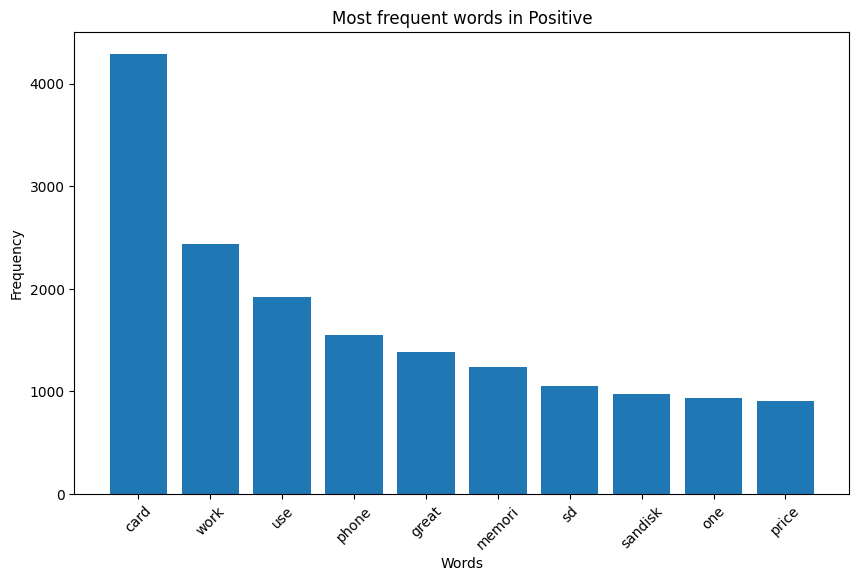

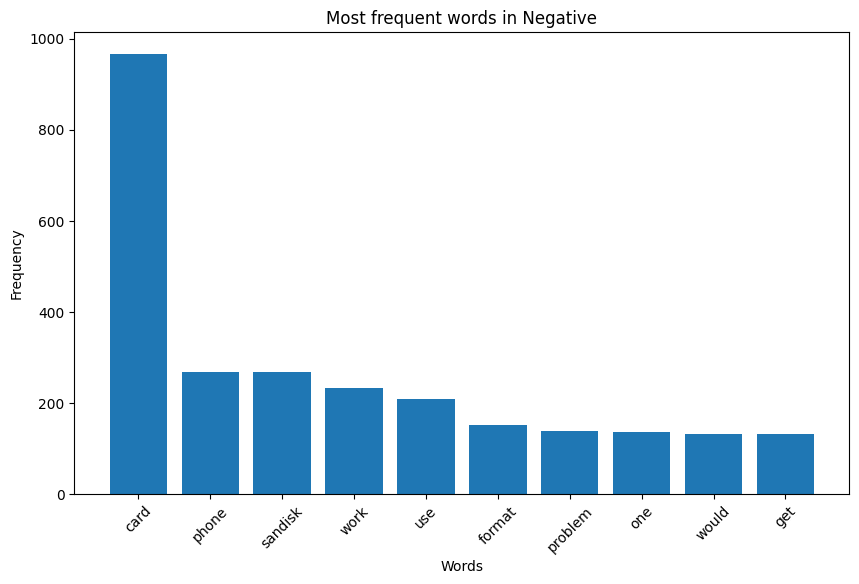

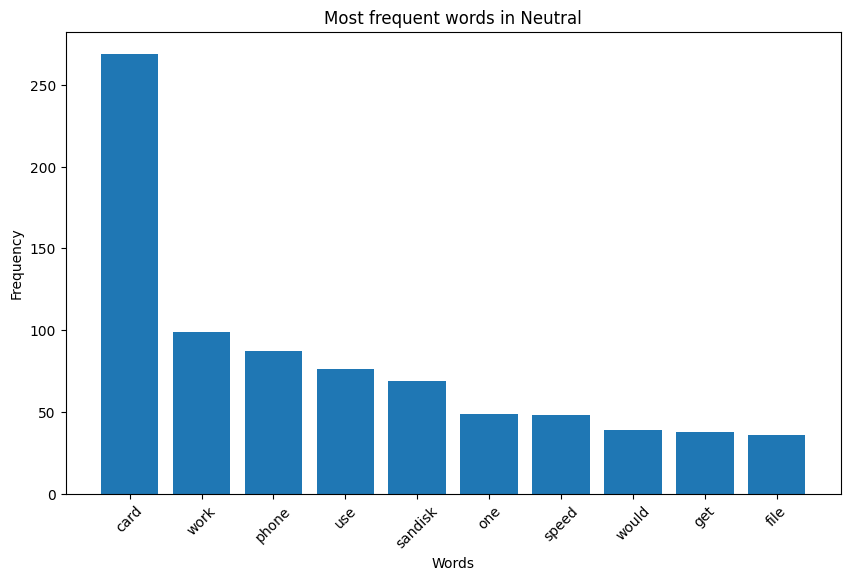

In [23]:
count_freqwords(positive_comments, 'Positive')
count_freqwords(negative_comments, 'Negative')
count_freqwords(neutral_comments, 'Neutral')

## Step 5:
The data will be now be split into train/test sets, then I will be using two different Vectorization methods and three different models testing accuracy scores
The two Vectorization methods are:
1. CountVectorize
2. TF-IDF Vectorizer

The three models I'll be testing are:
1. Naive Bayes
2. Logistic Regression
3. Support Vector Machines (SVM)

In [24]:
#Assigning X and y variables
X = reviews['reviewText']
y = reviews['overall']


In [25]:
#Creating the train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
#Creating a dictionary for the loop below
splits = {'X_train': X_train,
          'X_test': X_test,
          'y_train': y_train,
          'y_test': y_test}

#Simple function to check splits
def check_size(name, split):
    print(f'Size of {name}: {split.shape}')

In [27]:
for name, data in splits.items():
    check_size(name, data)

Size of X_train: (3928,)
Size of X_test: (982,)
Size of y_train: (3928,)
Size of y_test: (982,)


In [28]:
#Testing with the Count Vectorizer option
vectorizer = CountVectorizer()

X_train_df = pd.DataFrame(X_train, columns=['reviewText'])



In [29]:
X_train_vectorized = vectorizer.fit_transform(X_train_df['reviewText'])
X_test_vectorized = vectorizer.transform(X_test)
print(f"Shape of vectorized training set: {X_train_vectorized.shape}")

Shape of vectorized training set: (3928, 7627)


In [30]:
X_train_split, X_validation_split, y_train_split, y_validation_split = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)

## Testing using the MultinomialNB model

-----------------------------  VALIDATION ACCURACY   -----------------------------
Validation accuracy: 0.9478371501272265
--------------------------------  TEST ACCURACY   --------------------------------
Test accuracy: 0.9317718940936863
-------------------------------  PRECISION SCORE   -------------------------------
Precision: 0.9392982398452934
--------------------------------  RECALL SCORE   ---------------------------------
Recall: 0.9478371501272265
----------------------------------  F1 SCORE   -----------------------------------
F1 Score: 0.936089675741756
------------------------------  CONFUSION MATRIX   -------------------------------
[[ 51   0  15]
 [  5   2  17]
 [  3   1 692]]


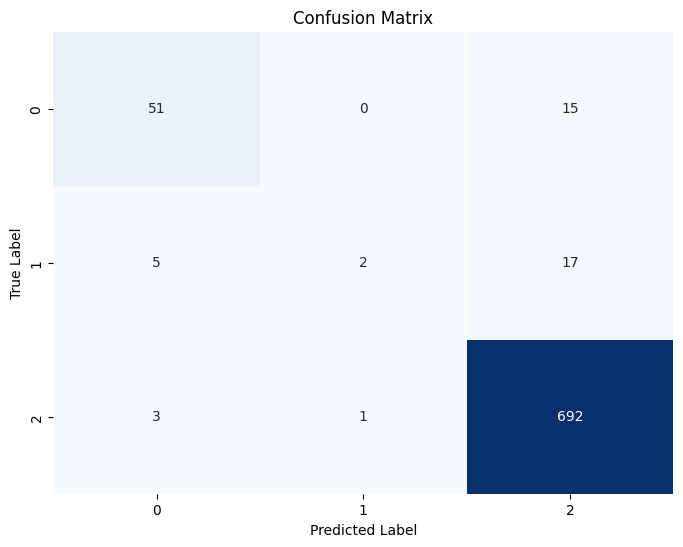

----------------------------  CLASSIFICATION REPORT   ----------------------------
              precision    recall  f1-score   support

    Negative       0.86      0.77      0.82        66
     Neutral       0.67      0.08      0.15        24
    Positive       0.96      0.99      0.97       696

    accuracy                           0.95       786
   macro avg       0.83      0.62      0.65       786
weighted avg       0.94      0.95      0.94       786



In [31]:
classifier = MultinomialNB()

classifier.fit(X_train_vectorized, y_train)

y_pred = classifier.predict(X_validation_split)

#Accuracy
accuracy_nb = accuracy_score(y_validation_split, y_pred)
print("  VALIDATION ACCURACY   ".center(82, '-'))
print(f"Validation accuracy: {accuracy_nb}")

#Test Accuracy
test_accuracy_nb = classifier.score(X_test_vectorized, y_test)
print("  TEST ACCURACY   ".center(82, '-'))
print(f"Test accuracy: {test_accuracy_nb}")

#Precision
precision_nb = precision_score(y_validation_split, y_pred, average='weighted')
print("  PRECISION SCORE   ".center(82, '-'))
print(f"Precision: {precision_nb}")

#Recall
recall_nb = recall_score(y_validation_split, y_pred, average='weighted')
print("  RECALL SCORE   ".center(82, '-'))
print(f"Recall: {recall_nb}")

#F1 score
f1_nb = f1_score(y_validation_split, y_pred, average='weighted')
print("  F1 SCORE   ".center(82, '-'))
print(f"F1 Score: {f1_nb}")

#Confusion Matrix
confusion_mat_nb = confusion_matrix(y_validation_split, y_pred)
print("  CONFUSION MATRIX   ".center(82, '-'))
print(confusion_mat_nb)
#Plotting the a visual graph for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_nb, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#Classification report
class_report_nb = classification_report(y_validation_split, y_pred)
print("  CLASSIFICATION REPORT   ".center(82, '-'))
print(class_report_nb)

## Testing using Logistic Regression

-----------------------------  VALIDATION ACCURACY   -----------------------------
Validation accuracy: 0.9936386768447837
--------------------------------  TEST ACCURACY   --------------------------------
Test accuracy: 0.9317718940936863
-------------------------------  PRECISION SCORE   -------------------------------
Precision: 0.9936840500484585
--------------------------------  RECALL SCORE   ---------------------------------
Recall: 0.9936386768447837
----------------------------------  F1 SCORE   -----------------------------------
F1 Score: 0.9935032609793685
------------------------------  CONFUSION MATRIX   -------------------------------
[[ 64   0   2]
 [  0  21   3]
 [  0   0 696]]


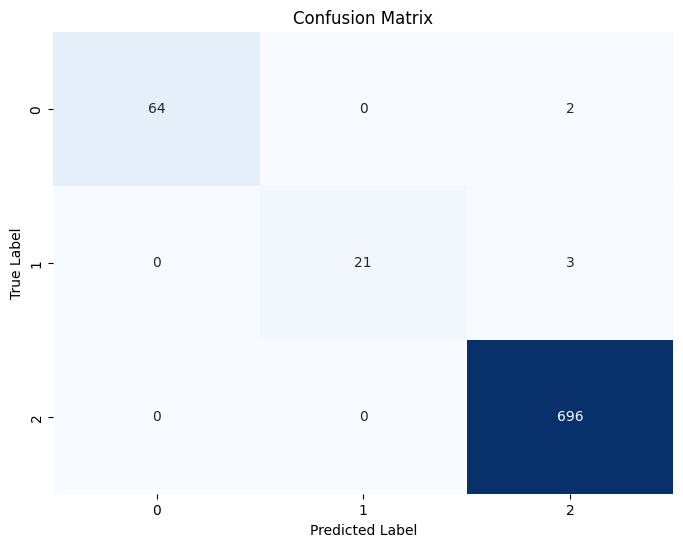

----------------------------  CLASSIFICATION REPORT   ----------------------------
              precision    recall  f1-score   support

    Negative       1.00      0.97      0.98        66
     Neutral       1.00      0.88      0.93        24
    Positive       0.99      1.00      1.00       696

    accuracy                           0.99       786
   macro avg       1.00      0.95      0.97       786
weighted avg       0.99      0.99      0.99       786



In [34]:
classifier = LogisticRegression()

classifier.fit(X_train_vectorized, y_train)

y_pred = classifier.predict(X_validation_split)

accuracy_lr = accuracy_score(y_validation_split, y_pred)
print("  VALIDATION ACCURACY   ".center(82, '-'))
print(f"Validation accuracy: {accuracy_lr}")

test_accuracy_lr = classifier.score(X_test_vectorized, y_test)
print("  TEST ACCURACY   ".center(82, '-'))
print(f"Test accuracy: {test_accuracy_lr}")

precision_lr = precision_score(y_validation_split, y_pred, average='weighted')
print("  PRECISION SCORE   ".center(82, '-'))
print(f"Precision: {precision_lr}")

recall_lr = recall_score(y_validation_split, y_pred, average='weighted')
print("  RECALL SCORE   ".center(82, '-'))
print(f"Recall: {recall_lr}")

f1_lr = f1_score(y_validation_split, y_pred, average='weighted')
print("  F1 SCORE   ".center(82, '-'))
print(f"F1 Score: {f1_lr}")

confusion_mat_lr = confusion_matrix(y_validation_split, y_pred)
print("  CONFUSION MATRIX   ".center(82, '-'))
print(confusion_mat_lr)

#Plotting the a visual graph for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_lr, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

class_report_lr = classification_report(y_validation_split, y_pred)
print("  CLASSIFICATION REPORT   ".center(82, '-'))
print(class_report_lr)

## Testing using SVC

-----------------------------  VALIDATION ACCURACY   -----------------------------
Validation accuracy: 0.9592875318066157
--------------------------------  TEST ACCURACY   --------------------------------
Test accuracy: 0.924643584521385
-------------------------------  PRECISION SCORE   -------------------------------
Precision: 0.96029926841863
--------------------------------  RECALL SCORE   ---------------------------------
Recall: 0.9592875318066157
----------------------------------  F1 SCORE   -----------------------------------
F1 Score: 0.9518021064837182
------------------------------  CONFUSION MATRIX   -------------------------------
[[ 52   0  14]
 [  2   6  16]
 [  0   0 696]]


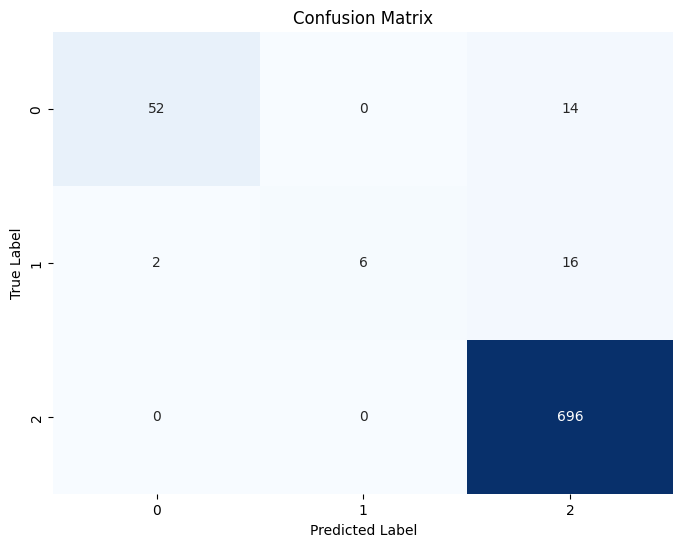

----------------------------  CLASSIFICATION REPORT   ----------------------------
              precision    recall  f1-score   support

    Negative       0.96      0.79      0.87        66
     Neutral       1.00      0.25      0.40        24
    Positive       0.96      1.00      0.98       696

    accuracy                           0.96       786
   macro avg       0.97      0.68      0.75       786
weighted avg       0.96      0.96      0.95       786



In [33]:
classifier = SVC()

classifier.fit(X_train_vectorized, y_train)

y_pred = classifier.predict(X_validation_split)

accuracy_svm = accuracy_score(y_validation_split, y_pred)
print("  VALIDATION ACCURACY   ".center(82, '-'))
print(f"Validation accuracy: {accuracy_svm}")

test_accuracy_svm = classifier.score(X_test_vectorized, y_test)
print("  TEST ACCURACY   ".center(82, '-'))
print(f"Test accuracy: {test_accuracy_svm}")

precision_svm = precision_score(y_validation_split, y_pred, average='weighted')
print("  PRECISION SCORE   ".center(82, '-'))
print(f"Precision: {precision_svm}")

recall_svm = recall_score(y_validation_split, y_pred, average='weighted')
print("  RECALL SCORE   ".center(82, '-'))
print(f"Recall: {recall_svm}")

f1_svm = f1_score(y_validation_split, y_pred, average='weighted')
print("  F1 SCORE   ".center(82, '-'))
print(f"F1 Score: {f1_svm}")

confusion_mat_svm = confusion_matrix(y_validation_split, y_pred)
print("  CONFUSION MATRIX   ".center(82, '-'))
print(confusion_mat_svm)

#Plotting the a visual graph for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_svm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


class_report_svm = classification_report(y_validation_split, y_pred)
print("  CLASSIFICATION REPORT   ".center(82, '-'))
print(class_report_svm)

In [36]:
results_1 = {
    'Model': ['MultinomialNB', 'Linear Regression', 'SVC'],
    'Validation Accuracy': [accuracy_nb, accuracy_lr, accuracy_svm],
    'Test Accuracy': [test_accuracy_nb, test_accuracy_lr, test_accuracy_svm],
    'Precision': [precision_nb, precision_lr, precision_svm],
    'Recall': [recall_nb, recall_lr, recall_svm],
    'F1 Score': [f1_nb, f1_lr, f1_svm],
    
}
count_vector_summary = pd.DataFrame(results_1)
count_vector_summary.style.highlight_max(subset = ['Validation Accuracy', 'Precision', 'Test Accuracy', 'Recall', 'F1 Score'],
                       color = 'green', axis = 0)

,Model,Validation Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,MultinomialNB,0.947837,0.931772,0.939298,0.947837,0.936090
1,Linear Regression,0.993639,0.931772,0.993684,0.993639,0.993503
2,SVC,0.959288,0.924644,0.960299,0.959288,0.951802


## Testing using the TFID Vectorizer

In [38]:
vectorizer_2 = TfidfVectorizer()
X_train_df_2 = pd.DataFrame(X_train, columns=['reviewText'])
X_train_vectorized_2 = vectorizer_2.fit_transform(X_train_df_2['reviewText'])
X_test_vectorized_2 = vectorizer_2.transform(X_test)
print(f"Shape of vectorized training set: {X_train_vectorized_2.shape}")

Shape of vectorized training set: (3928, 7627)


In [39]:
X_train_split_2, X_validation_split_2, y_train_split_2, y_validation_split_2 = train_test_split(X_train_vectorized_2, y_train, test_size=0.2, random_state=42)

## Testing using MultinomiaNB Model

-----------------------------  VALIDATION ACCURACY   -----------------------------
Validation accuracy: 0.8854961832061069
--------------------------------  TEST ACCURACY   --------------------------------
Test accuracy: 0.9205702647657841
-------------------------------  PRECISION SCORE   -------------------------------
Precision: 0.7841034904725832
--------------------------------  RECALL SCORE   ---------------------------------
Recall: 0.8854961832061069
----------------------------------  F1 SCORE   -----------------------------------
F1 Score: 0.8317211113514851
------------------------------  CONFUSION MATRIX   -------------------------------
[[  0   0  66]
 [  0   0  24]
 [  0   0 696]]


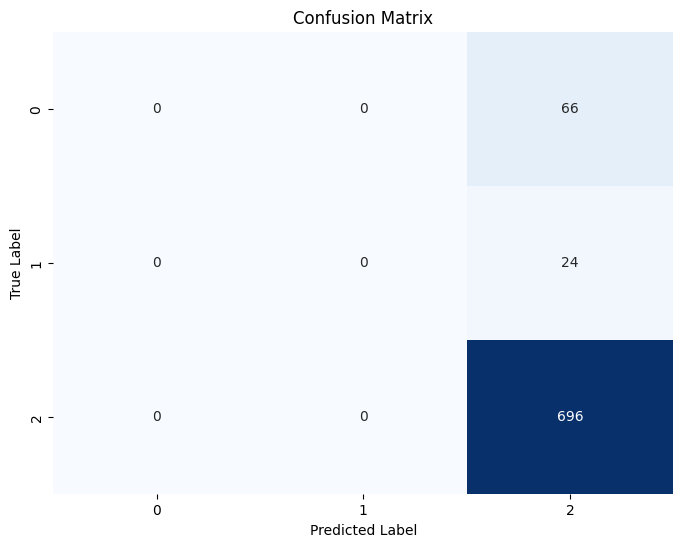

----------------------------  CLASSIFICATION REPORT   ----------------------------
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        66
     Neutral       0.00      0.00      0.00        24
    Positive       0.89      1.00      0.94       696

    accuracy                           0.89       786
   macro avg       0.30      0.33      0.31       786
weighted avg       0.78      0.89      0.83       786



In [40]:
classifier = MultinomialNB()

classifier.fit(X_train_vectorized_2, y_train)

y_pred_2 = classifier.predict(X_validation_split_2)

accuracy_nb_2 = accuracy_score(y_validation_split_2, y_pred_2)
print("  VALIDATION ACCURACY   ".center(82, '-'))
print(f"Validation accuracy: {accuracy_nb_2}")

test_accuracy_nb_2 = classifier.score(X_test_vectorized_2, y_test)
print("  TEST ACCURACY   ".center(82, '-'))
print(f"Test accuracy: {test_accuracy_nb_2}")

precision_nb_2 = precision_score(y_validation_split_2, y_pred_2, average='weighted')
print("  PRECISION SCORE   ".center(82, '-'))
print(f"Precision: {precision_nb_2}")

recall_nb_2 = recall_score(y_validation_split_2, y_pred_2, average='weighted')
print("  RECALL SCORE   ".center(82, '-'))
print(f"Recall: {recall_nb_2}")

f1_nb_2 = f1_score(y_validation_split_2, y_pred_2, average='weighted')
print("  F1 SCORE   ".center(82, '-'))
print(f"F1 Score: {f1_nb_2}")

confusion_mat_nb_2 = confusion_matrix(y_validation_split_2, y_pred_2)
print("  CONFUSION MATRIX   ".center(82, '-'))
print(confusion_mat_nb_2)

#Plotting the a visual graph for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_nb_2, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

class_report_nb_2 = classification_report(y_validation_split_2, y_pred_2)
print("  CLASSIFICATION REPORT   ".center(82, '-'))
print(class_report_nb_2)

## Testing using Logistic Regression

-----------------------------  VALIDATION ACCURACY   -----------------------------
Validation accuracy: 0.926208651399491
--------------------------------  TEST ACCURACY   --------------------------------
Test accuracy: 0.9368635437881874
-------------------------------  PRECISION SCORE   -------------------------------
Precision: 0.8963799830364716
--------------------------------  RECALL SCORE   ---------------------------------
Recall: 0.926208651399491
----------------------------------  F1 SCORE   -----------------------------------
F1 Score: 0.9051145845560676
------------------------------  CONFUSION MATRIX   -------------------------------
[[ 32   0  34]
 [  4   0  20]
 [  0   0 696]]


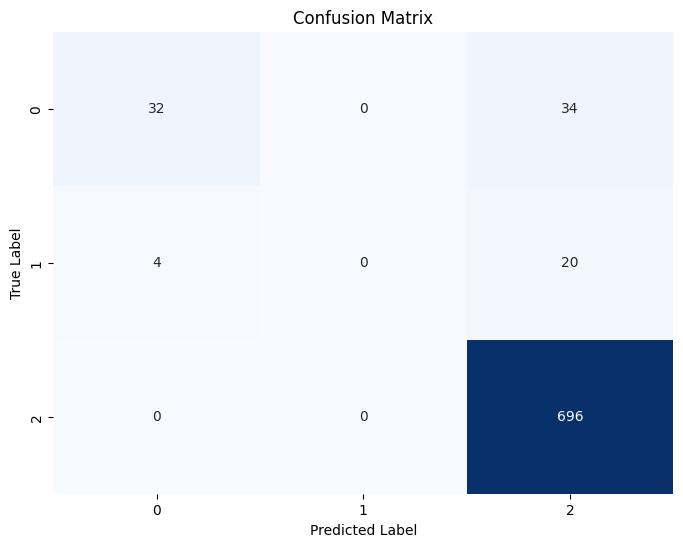

----------------------------  CLASSIFICATION REPORT   ----------------------------
              precision    recall  f1-score   support

    Negative       0.89      0.48      0.63        66
     Neutral       0.00      0.00      0.00        24
    Positive       0.93      1.00      0.96       696

    accuracy                           0.93       786
   macro avg       0.61      0.49      0.53       786
weighted avg       0.90      0.93      0.91       786



In [41]:
classifier = LogisticRegression()

classifier.fit(X_train_vectorized_2, y_train)

y_pred_2 = classifier.predict(X_validation_split_2)

accuracy_lr_2 = accuracy_score(y_validation_split_2, y_pred_2)
print("  VALIDATION ACCURACY   ".center(82, '-'))
print(f"Validation accuracy: {accuracy_lr_2}")

test_accuracy_lr_2 = classifier.score(X_test_vectorized_2, y_test)
print("  TEST ACCURACY   ".center(82, '-'))
print(f"Test accuracy: {test_accuracy_lr_2}")

precision_lr_2 = precision_score(y_validation_split_2, y_pred_2, average='weighted')
print("  PRECISION SCORE   ".center(82, '-'))
print(f"Precision: {precision_lr_2}")

recall_lr_2 = recall_score(y_validation_split_2, y_pred_2, average='weighted')
print("  RECALL SCORE   ".center(82, '-'))
print(f"Recall: {recall_lr_2}")

f1_lr_2 = f1_score(y_validation_split_2, y_pred_2, average='weighted')
print("  F1 SCORE   ".center(82, '-'))
print(f"F1 Score: {f1_lr_2}")

confusion_mat_lr_2 = confusion_matrix(y_validation_split_2, y_pred_2)
print("  CONFUSION MATRIX   ".center(82, '-'))
print(confusion_mat_lr_2)

#Plotting the a visual graph for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_lr_2, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

class_report_lr_2 = classification_report(y_validation_split_2, y_pred_2)
print("  CLASSIFICATION REPORT   ".center(82, '-'))
print(class_report_lr_2)

## Testing using SVC

-----------------------------  VALIDATION ACCURACY   -----------------------------
Validation accuracy: 0.9669211195928753
--------------------------------  TEST ACCURACY   --------------------------------
Test accuracy: 0.9348268839103869
-------------------------------  PRECISION SCORE   -------------------------------
Precision: 0.967798460868777
--------------------------------  RECALL SCORE   ---------------------------------
Recall: 0.9669211195928753
----------------------------------  F1 SCORE   -----------------------------------
F1 Score: 0.9552830991477212
------------------------------  CONFUSION MATRIX   -------------------------------
[[ 62   0   4]
 [  3   2  19]
 [  0   0 696]]


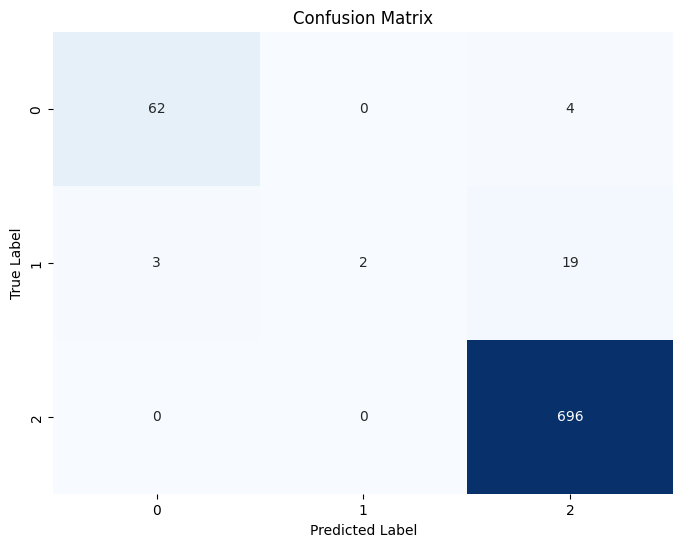

----------------------------  CLASSIFICATION REPORT   ----------------------------
              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95        66
     Neutral       1.00      0.08      0.15        24
    Positive       0.97      1.00      0.98       696

    accuracy                           0.97       786
   macro avg       0.97      0.67      0.69       786
weighted avg       0.97      0.97      0.96       786



In [42]:
classifier = SVC()

classifier.fit(X_train_vectorized_2, y_train)

y_pred_2 = classifier.predict(X_validation_split_2)

accuracy_svm_2 = accuracy_score(y_validation_split_2, y_pred_2)
print("  VALIDATION ACCURACY   ".center(82, '-'))
print(f"Validation accuracy: {accuracy_svm_2}")

test_accuracy_svm_2 = classifier.score(X_test_vectorized_2, y_test)
print("  TEST ACCURACY   ".center(82, '-'))
print(f"Test accuracy: {test_accuracy_svm_2}")

precision_svm_2 = precision_score(y_validation_split_2, y_pred_2, average='weighted')
print("  PRECISION SCORE   ".center(82, '-'))
print(f"Precision: {precision_svm_2}")

recall_svm_2 = recall_score(y_validation_split_2, y_pred_2, average='weighted')
print("  RECALL SCORE   ".center(82, '-'))
print(f"Recall: {recall_svm_2}")

f1_svm_2 = f1_score(y_validation_split_2, y_pred_2, average='weighted')
print("  F1 SCORE   ".center(82, '-'))
print(f"F1 Score: {f1_svm_2}")

confusion_mat_svm_2 = confusion_matrix(y_validation_split_2, y_pred_2)
print("  CONFUSION MATRIX   ".center(82, '-'))
print(confusion_mat_svm_2)

#Plotting the a visual graph for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_svm_2, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

class_report_svm_2 = classification_report(y_validation_split_2, y_pred_2)
print("  CLASSIFICATION REPORT   ".center(82, '-'))
print(class_report_svm_2)

In [43]:
results_2 = {
    'Model': ['MultinomialNB', 'Linear Regression', 'SVC'],
    'Validation Accuracy': [accuracy_nb_2, accuracy_lr_2, accuracy_svm_2],
    'Test Accuracy': [test_accuracy_nb_2, test_accuracy_lr_2, test_accuracy_svm_2],
    'Precision': [precision_nb_2, precision_lr_2, precision_svm_2],
    'Recall': [recall_nb_2, recall_lr_2, recall_svm_2],
    'F1 Score': [f1_nb_2, f1_lr_2, f1_svm_2],
    
}
tfid_vector_summary = pd.DataFrame(results_2)
tfid_vector_summary.style.highlight_max(subset = ['Validation Accuracy', 'Precision', 'Test Accuracy', 'Recall', 'F1 Score'],
                       color = 'green', axis = 0)

,Model,Validation Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,MultinomialNB,0.885496,0.920570,0.784103,0.885496,0.831721
1,Linear Regression,0.926209,0.936864,0.896380,0.926209,0.905115
2,SVC,0.966921,0.934827,0.967798,0.966921,0.955283


The Count Vectorization method returns the best results consistently, Logistic Regression appears to be the best model, achieving 99% accuracy on the count vectorization method and 92% on the TFID Vectorization Method. For TFID Vectorization the best overall model was SVC with an accuracy score of 96%. 